# Lab 02 - Pandas Introduction 
We start by importing two datasets:
- The *New York Point Of Interest* dataset collects a sub-sample of the point of interests available in
the city of New York
- The *US Flight Delay Data* dataset is made available by the Bureau of Transportation Statistics of the United States Department of Transportation and measures the performance of flight carriers.

In [ ]:
!curl -L -o NYC_POIs.zip "https://github.com/dbdmg/data-science-lab/raw/master/datasets/NYC_POIs.zip"
!unzip NYC_POIs.zip -d NYC_POIs

In [ ]:
!curl -L -o US_FlightDelayData.zip "https://github.com/dbdmg/data-science-lab/raw/master/datasets/US_FlightDelayData.zip"
!unzip US_FlightDelayData.zip -d US_FlightDelayData

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import *

## Data exploration of Point of Interest

In [2]:
initial_df = pd.read_csv("NYC_POIs/pois_all_info", sep="\t", low_memory=False)
ny = pd.read_csv("NYC_POIs/ny_municipality_pois_id.csv", sep="\t")
ny.columns = ['@id']
df = pd.merge(initial_df, ny, on='@id')
df.dtypes

@id                   int64
@type                object
@lat                float64
@lon                float64
amenity              object
name                 object
shop                 object
public_transport     object
highway              object
dtype: object

In [3]:
df.isnull().sum()

@id                     0
@type                   0
@lat                    0
@lon                    0
amenity             28837
name                22999
shop                44832
public_transport    45174
highway             45990
dtype: int64

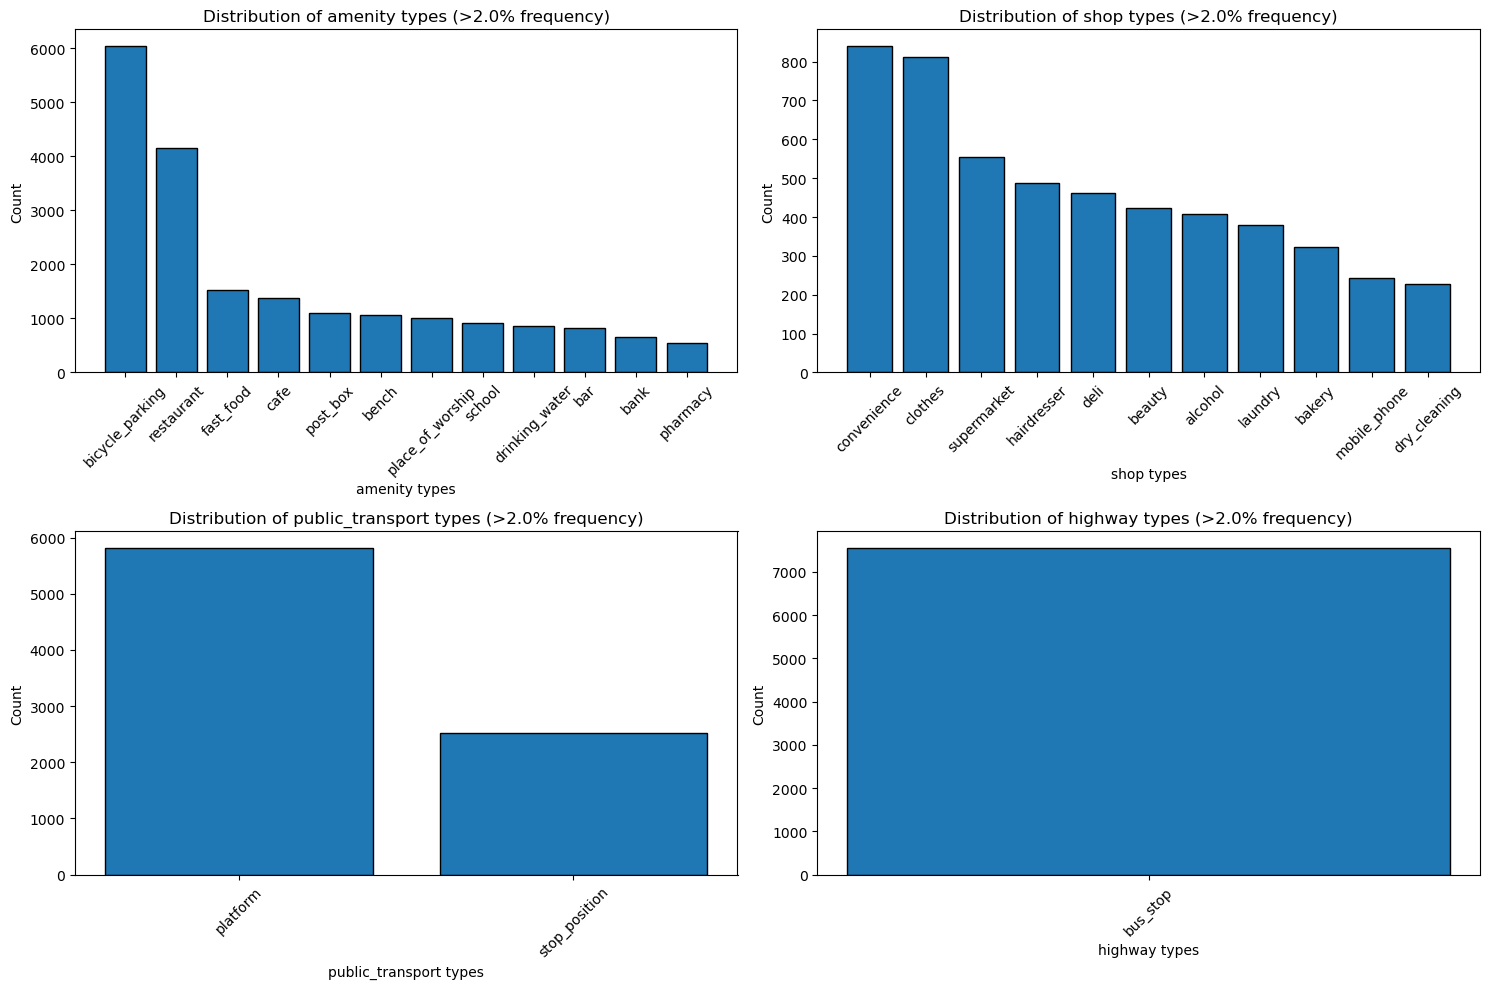

In [4]:
poi_categories = ['amenity', 'shop', 'public_transport', 'highway']
threshold_percent = 2.0 

fig, axes = plt.subplots(2, 2, figsize=(15, 10)) 
axes = axes.flatten()

top_poi_types = {}
for i, category in enumerate(poi_categories):
    data = df[category].dropna()
    counts = data.value_counts()
    total = counts.sum()
    
    filtered_counts = counts[counts / total * 100 > threshold_percent]
    top_poi_types[category] = filtered_counts

    axes[i].bar(filtered_counts.index, filtered_counts.values, edgecolor='black')
    axes[i].set_title(f'Distribution of {category} types (>{threshold_percent}% frequency)')
    axes[i].set_xlabel(f'{category} types')
    axes[i].set_ylabel('Count')
    axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

In [5]:
import matplotlib.pyplot as plt

def plot_poi_on_nyc_map(poi_category, df, top_poi_types, map_path='NYC_POIs/New_York_City_Map.png'):
    img = plt.imread(map_path)
    
    if poi_category not in top_poi_types:
        print(f"No data for category '{poi_category}'")
        return
        
    poi_types = top_poi_types[poi_category].index
    subset = df[df[poi_category].isin(poi_types)]
    
    lat_min, lat_max = subset['@lat'].min(), subset['@lat'].max()
    lon_min, lon_max = subset['@lon'].min(), subset['@lon'].max()
    plt.imshow(img, extent=[lon_min, lon_max, lat_min, lat_max])
    colors = plt.colormaps['tab20'].resampled(len(poi_types))
    
    for i, poi_type in enumerate(poi_types):
        data = subset[subset[poi_category] == poi_type]
        plt.scatter(data['@lon'], data['@lat'], s=10, color=colors(i), label=poi_type, alpha=0.7)

    plt.legend(fontsize='small', loc='best')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title(f'POI locations: {poi_category}')
    plt.show()


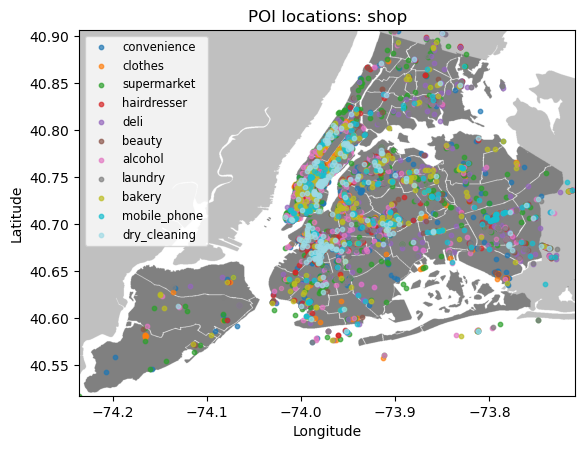

In [6]:
plot_poi_on_nyc_map('shop', df, top_poi_types)

In [7]:
def assign_poi_to_grid(df, lat_col='@lat', lon_col='@lon', 
                       lat_bins=10, lon_bins=10):
    df_copy = df.copy()
    
    lat_min, lat_max = df_copy[lat_col].min(), df_copy[lat_col].max()
    lon_min, lon_max = df_copy[lon_col].min(), df_copy[lon_col].max()
    
    lat_edges = np.linspace(lat_min, lat_max, lat_bins + 1)
    lon_edges = np.linspace(lon_min, lon_max, lon_bins + 1)
    
    lat_indices = np.digitize(df_copy[lat_col], lat_edges) - 1  
    lon_indices = np.digitize(df_copy[lon_col], lon_edges) - 1
    
    lat_indices[lat_indices == lat_bins] = lat_bins - 1
    lon_indices[lon_indices == lon_bins] = lon_bins - 1
    
    df_copy['cell_id'] = [f"{row}_{col}" for row, col in zip(lat_indices, lon_indices)]
    
    return df_copy

df_copy=assign_poi_to_grid(df)

In [8]:
result_frames = []

for category in poi_categories:
    grouped = df_copy.groupby(['cell_id', category]).size().reset_index(name='counts')
    pivot_table = grouped.pivot(index='cell_id', columns=category, values='counts').fillna(0)
    result_frames.append(pivot_table)

final_df = result_frames[0]

for df_to_merge in result_frames[1:]:
    final_df = pd.merge(final_df, df_to_merge, left_index=True, right_index=True, how='outer')

final_df.fillna(0, inplace=True)

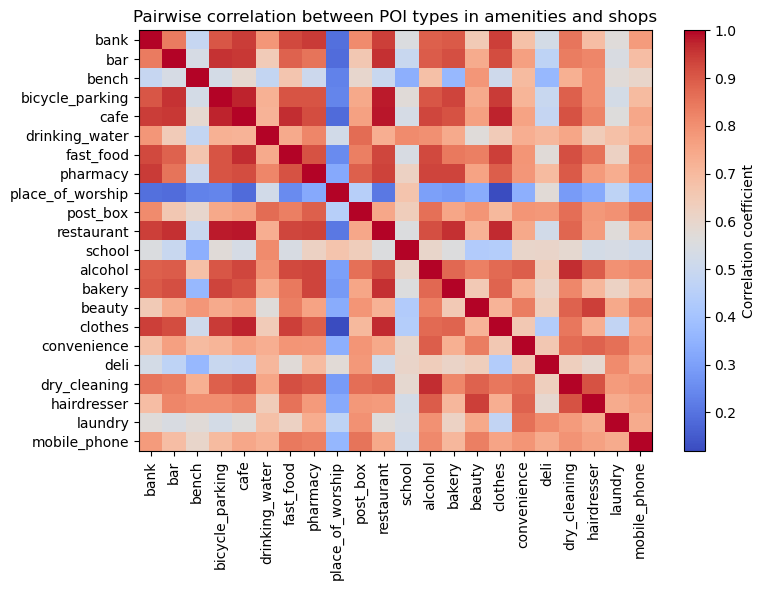

In [9]:
amenity_types = top_poi_types['amenity'].index.tolist()
shop_types = top_poi_types['shop'].index.tolist()

amenity_cols = [col for col in final_df.columns if col in amenity_types]
shop_cols = [col for col in final_df.columns if col in shop_types]

cols_to_use = amenity_cols + shop_cols

subset = final_df[cols_to_use]

corr_matrix = subset.corr()

plt.figure(figsize=(8, 6))
plt.imshow(corr_matrix, cmap='coolwarm', interpolation='nearest', aspect='auto')
plt.colorbar(label='Correlation coefficient')
plt.xticks(range(len(corr_matrix.columns)), corr_matrix.columns, rotation=90)
plt.yticks(range(len(corr_matrix.index)), corr_matrix.index)
plt.title('Pairwise correlation between POI types in amenities and shops')
plt.tight_layout()
plt.show()

## Data exploration and queries on Flight Delay Data

In [10]:
df2 = pd.read_csv("US_FlightDelayData/831394006_T_ONTIME.csv", sep=",",parse_dates=['FL_DATE'])
df2.info()
df2.describe() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 450017 entries, 0 to 450016
Data columns (total 33 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   FL_DATE                450017 non-null  datetime64[ns]
 1   UNIQUE_CARRIER         450017 non-null  object        
 2   AIRLINE_ID             450017 non-null  int64         
 3   TAIL_NUM               449378 non-null  object        
 4   FL_NUM                 450017 non-null  int64         
 5   ORIGIN_AIRPORT_ID      450017 non-null  int64         
 6   ORIGIN_AIRPORT_SEQ_ID  450017 non-null  int64         
 7   ORIGIN_CITY_MARKET_ID  450017 non-null  int64         
 8   ORIGIN                 450017 non-null  object        
 9   ORIGIN_CITY_NAME       450017 non-null  object        
 10  DEST_AIRPORT_ID        450017 non-null  int64         
 11  DEST_AIRPORT_SEQ_ID    450017 non-null  int64         
 12  DEST_CITY_MARKET_ID    450017 non-null  int6

,FL_DATE,AIRLINE_ID,FL_NUM,ORIGIN_AIRPORT_ID,ORIGIN_AIRPORT_SEQ_ID,ORIGIN_CITY_MARKET_ID,DEST_AIRPORT_ID,DEST_AIRPORT_SEQ_ID,DEST_CITY_MARKET_ID,CRS_DEP_TIME,...,CRS_ARR_TIME,ARR_TIME,ARR_DELAY,CANCELLED,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,SECURITY_DELAY,LATE_AIRCRAFT_DELAY,Unnamed: 32
count,450017,450017.000000,450017.000000,450017.000000,4.500170e+05,450017.000000,450017.000000,4.500170e+05,450017.000000,450017.000000,...,450017.000000,440746.000000,439645.000000,450017.000000,97699.000000,97699.000000,97699.000000,97699.000000,97699.000000,0.0
mean,2017-01-15 22:38:34.552561152,19900.483275,2079.643193,12698.267568,1.269830e+06,31738.603264,12698.024626,1.269805e+06,31738.404640,1327.757407,...,1506.278285,1487.332958,6.954484,0.019746,20.308836,3.368857,15.742495,0.079745,24.947492,NaN
min,2017-01-01 00:00:00,19393.000000,1.000000,10135.000000,1.013503e+06,30070.000000,10135.000000,1.013503e+06,30070.000000,5.000000,...,1.000000,1.000000,-98.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN
25%,2017-01-08 00:00:00,19690.000000,679.000000,11292.000000,1.129202e+06,30647.000000,11292.000000,1.129202e+06,30647.000000,917.000000,...,1120.000000,1108.000000,-15.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN
50%,2017-01-16 00:00:00,19805.000000,1602.000000,12892.000000,1.289204e+06,31454.000000,12892.000000,1.289204e+06,31454.000000,1321.000000,...,1529.000000,1521.000000,-5.000000,0.000000,0.000000,0.000000,4.000000,0.000000,3.000000,NaN
75%,2017-01-24 00:00:00,20304.000000,3034.000000,14057.000000,1.405702e+06,32467.000000,14057.000000,1.405702e+06,32467.000000,1730.000000,...,1921.000000,1921.000000,11.000000,0.000000,17.000000,0.000000,20.000000,0.000000,31.000000,NaN
max,2017-01-31 00:00:00,21171.000000,7439.000000,16218.000000,1.621801e+06,35991.000000,16218.000000,1.621801e+06,35991.000000,2359.000000,...,2359.000000,2400.000000,1944.000000,1.000000,1934.000000,1934.000000,1457.000000,653.000000,1392.000000,NaN
std,NaN,385.381448,1722.700045,1534.326936,1.534324e+05,1286.063689,1534.246611,1.534244e+05,1285.791081,481.548320,...,501.853851,523.821795,49.595992,0.139126,60.649157,27.809756,32.328181,2.896287,47.850860,NaN


In [11]:
df2=df2[df2["DEP_TIME"].notna()]
v1=df2["UNIQUE_CARRIER"].value_counts().sort_values()
df_copy = df2.copy()
df_copy['TOTAL_DELAY'] = df_copy[['CARRIER_DELAY', 'WEATHER_DELAY', 'NAS_DELAY', 'SECURITY_DELAY', 'LATE_AIRCRAFT_DELAY']].sum(axis=1)
mean_delay=df_copy.groupby('UNIQUE_CARRIER')['TOTAL_DELAY'].mean().sort_values()
print(v1,mean_delay)

UNIQUE_CARRIER
VX      5648
HA      6258
F9      7603
NK     12140
AS     14469
B6     24088
EV     33917
UA     42192
OO     48366
DL     69078
AA     72214
WN    105503
Name: count, dtype: int64 UNIQUE_CARRIER
HA     6.337488
AA    10.735467
AS    10.965996
WN    11.592050
DL    14.351472
UA    14.609499
NK    16.033690
B6    16.746098
OO    19.138114
F9    19.657504
EV    20.693192
VX    20.738314
Name: TOTAL_DELAY, dtype: float64


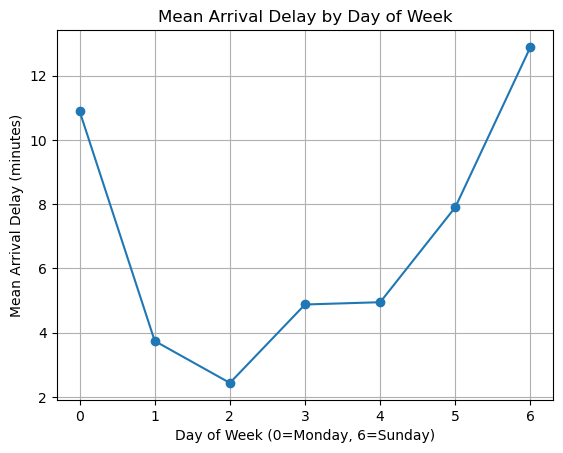

In [12]:
df2['WEEKDAY']=df2['FL_DATE'].dt.dayofweek
df2['DELAY_DELTA']=df2['ARR_DELAY']-df2['DEP_DELAY']

means = df2.groupby('WEEKDAY')['ARR_DELAY'].mean()

plt.plot(means.index, means.values, marker='o')
plt.xlabel('Day of Week (0=Monday, 6=Sunday)')
plt.ylabel('Mean Arrival Delay (minutes)')
plt.title('Mean Arrival Delay by Day of Week')
plt.grid(True)
plt.show()

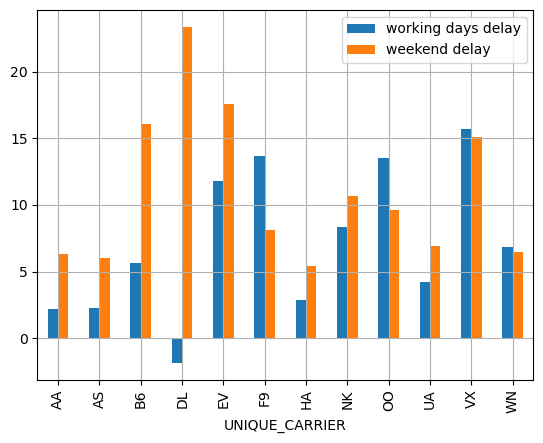

In [13]:
weekend_delay_mean=df2[(df2['WEEKDAY'] == 5) | (df2['WEEKDAY'] == 6)].groupby('UNIQUE_CARRIER')['ARR_DELAY'].mean()
weekday_delay_mean = df2[df2['WEEKDAY'].isin(range(0,5))].groupby('UNIQUE_CARRIER')['ARR_DELAY'].mean()
weekend_delay_mean.name = "weekend delay"
weekday_delay_mean.name = "working days delay"
delay_comparison = pd.concat([weekday_delay_mean, weekend_delay_mean], axis=1).plot.bar()
delay_comparison.grid(True)

In [14]:
df3=df2.set_index(['UNIQUE_CARRIER', 'ORIGIN', 'DEST', 'FL_DATE']).sort_index()
df3[df3.columns[:4]].head()

AIRLINE_ID TAIL_NUM  FL_NUM  \
UNIQUE_CARRIER ORIGIN DEST FL_DATE                                   
AA             ABQ    DFW  2017-01-01       19805   N4XSAA    1282   
                           2017-01-01       19805   N3NRAA    2611   
                           2017-01-01       19805   N4WNAA    2402   
                           2017-01-02       19805   N4XKAA    2611   
                           2017-01-02       19805   N4XBAA    2402   

                                       ORIGIN_AIRPORT_ID  
UNIQUE_CARRIER ORIGIN DEST FL_DATE                        
AA             ABQ    DFW  2017-01-01              10140  
                           2017-01-01              10140  
                           2017-01-01              10140  
                           2017-01-02              10140  
                           2017-01-02              10140

In [15]:
df3.loc[(['AA', 'DL'], ['LAX']), ['DEP_TIME', 'DEP_DELAY']]

DEP_TIME  DEP_DELAY
UNIQUE_CARRIER ORIGIN DEST FL_DATE                        
AA             LAX    ATL  2017-01-01    1051.0       16.0
                           2017-01-01    1747.0      137.0
                           2017-01-02    1548.0       18.0
                           2017-01-02    2230.0       40.0
                           2017-01-02    1055.0       20.0
...                                         ...        ...
DL             LAX    TPA  2017-01-26    1146.0        1.0
                           2017-01-27    1137.0       -3.0
                           2017-01-29    1149.0        4.0
                           2017-01-30    1142.0       -3.0
                           2017-01-31    1206.0       21.0

[5440 rows x 2 columns]

In [16]:
fw_df = df3.loc[(slice(None), slice(None), 'LAX', slice('2017-01-01','2017-01-08')), :]
fw_df.groupby('FL_NUM')['ARR_DELAY'].mean()

FL_NUM
1        0.000000
2       60.000000
4       11.625000
5        2.875000
7       16.750000
          ...    
6344    47.000000
6354    60.000000
6522    49.666667
6563    -8.000000
6710    10.000000
Name: ARR_DELAY, Length: 1106, dtype: float64

In [17]:
cfd = pd.pivot_table(df2, values='FL_NUM', index='UNIQUE_CARRIER', columns='WEEKDAY', aggfunc='count')
cfd

WEEKDAY,0,1,2,3,4,5,6
UNIQUE_CARRIER,,,,,,,
AA,12048,11465,9654,9859,9826,7918,11444
AS,2442,2269,1807,1935,1953,1764,2299
B6,4067,3944,3143,3258,3171,2646,3859
DL,12157,11513,9248,9696,9545,6495,10424
EV,5944,5654,4627,4926,4782,2910,5074
F9,1239,1216,977,984,986,956,1245
HA,987,966,791,802,864,826,1022
NK,1954,1972,1616,1610,1565,1475,1948
OO,8341,7931,6429,6636,6681,4923,7425


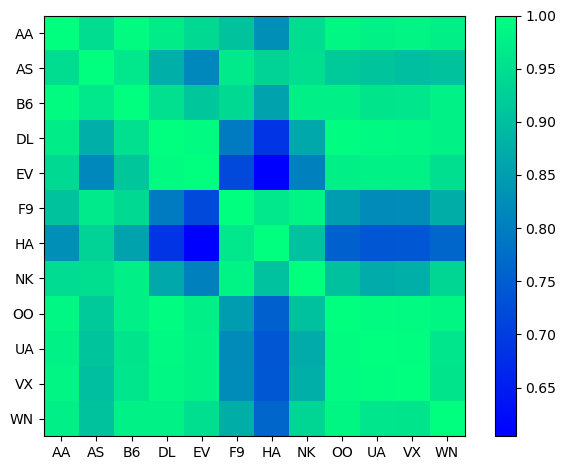

In [18]:
corr = cfd.T.corr()

plt.imshow(corr,cmap='winter' ,interpolation='none')
plt.colorbar()
plt.xticks(range(len(corr)), corr.columns)
plt.yticks(range(len(corr)), corr.columns)
plt.tight_layout()
plt.show()

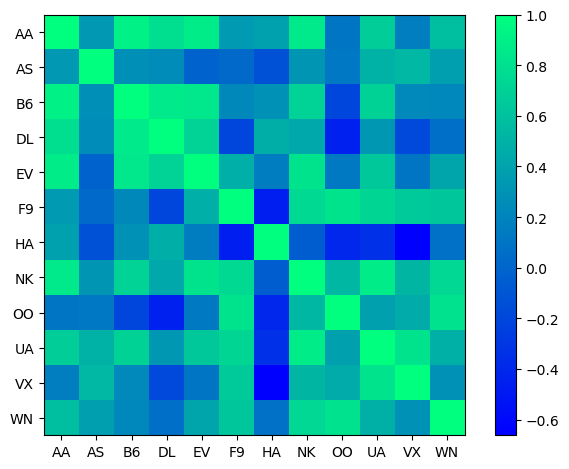

In [19]:
cfd2= pd.pivot_table(df2, values='ARR_DELAY', index='UNIQUE_CARRIER', columns='WEEKDAY', aggfunc='mean')
corr2 = cfd2.T.corr()

plt.imshow(corr2,cmap='winter' ,interpolation='none')
plt.colorbar()
plt.xticks(range(len(corr2)), corr2.columns)
plt.yticks(range(len(corr2)), corr2.columns)
plt.tight_layout()
plt.show()

In [20]:
mask = df2.UNIQUE_CARRIER.isin(["HA", "DL", "AA", "AS"])
dcw = pd.pivot_table(df2.loc[mask], values='DELAY_DELTA', index='UNIQUE_CARRIER', columns='WEEKDAY', aggfunc='mean')
dcw

WEEKDAY,0,1,2,3,4,5,6
UNIQUE_CARRIER,,,,,,,
AA,-3.576209,-4.621619,-4.601184,-4.091436,-3.553686,-4.558771,-3.747053
AS,-1.690789,-1.625446,-1.889198,-2.130705,-2.624551,-3.453872,0.542632
DL,-8.913563,-10.211625,-10.544913,-10.604603,-9.623199,-5.979988,-7.001644
HA,0.258359,0.307772,0.759189,0.390762,0.746528,1.330508,1.207066


<Axes: xlabel='WEEKDAY'>

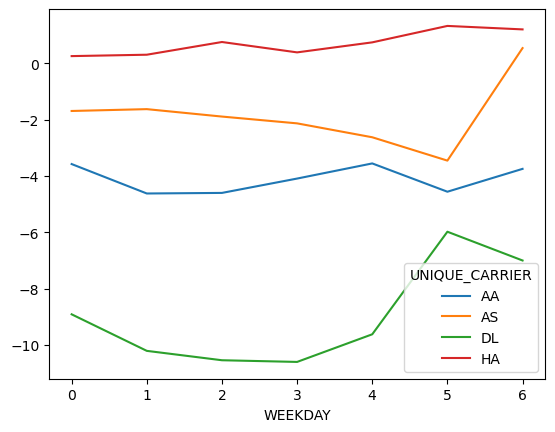

In [21]:
dcw.T.plot()